In [356]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots

from nanonets.utils import load_simulation_results, BLUE_COLOR
from nanonets import Simulation
from scipy.optimize import curve_fit

plt.style.use(["science","bright","grid"])

def solve_kcl_network(n, electrode_potentials, n_electrodes):
    """
    Solves the Kirchhoff's Current Law (KCL) equations for a linear resistor network.
    
    This function simulates the "Ohmic Limit" (High Temperature / High Bias) of the 
    nanoparticle network where Coulomb blockade effects are negligible. It solves the 
    linear matrix equation G * Phi = I to find node potentials and electrode currents.

    Parameters
    ----------
    n : int
        The linear dimension of the square lattice (total particles = n * n).
    electrode_potentials : np.ndarray
        A 2D array of shape (N_samples, n_electrodes) containing the boundary 
        conditions (control voltages) for each sample to be solved.
    n_electrodes : int
        The number of electrodes connected to the system (N_E).

    Returns
    -------
    phi_kcl : np.ndarray
        The computed potentials at the internal lattice nodes. 
        Shape: (N_samples, N_particles).
    I_electrodes_kcl : np.ndarray
        The computed net currents flowing out of the electrodes into the network.
        Shape: (N_samples, n_electrodes).
    """

    # 1. Define Topology
    topo = {
        "Nx": n, "Ny": n,
        "e_pos": [[0, 0], [int((n-1)/2), 0], [n-1, 0],
            [0, int((n-1)/2)],[0, n-1],[n-1, int(n/2)],[int(n/2), n-1],[n-1, n-1]],
        "electrode_type": ['constant'] * n_electrodes
    }

    # 2. Build System Matrix (Conductance)
    sim = Simulation(topo)
    sim.build_conductance_matrix()
    g_mat = sim.get_conductance_matrix()
    
    # 3. Partition the Matrix
    # g_mat is typically structured as [[G_int, G_coup], [G_coup.T, G_elec]]
    # We extract the internal block (NP-to-NP) and the coupling block (NP-to-Electrode)
    g_int = g_mat[:-n_electrodes, :-n_electrodes]  # Shape: (N_p, N_p)
    g_e   = g_mat[:-n_electrodes, -n_electrodes:]  # Shape: (N_p, N_e)

    # 4. Setup Linear Equation System (Ax = b)
    # The KCL equation for internal nodes is: G_int * Phi_int + G_e * V_ext = 0
    # Rearranging for Phi_int: G_int * Phi_int = - G_e * V_ext
    # Compute RHS vector (Currents injected by fixed boundaries)
    # Shape: (N_p, N_samples)
    volt = electrode_potentials
    rhs = -g_e @ volt.T

    # 5. Solve for Internal Potentials
    # We solve G_int * x = rhs for all samples simultaneously
    # Result transposed back to (N_samples, N_p)
    phi_kcl = np.linalg.solve(g_int, rhs).T

    # 6. Calculate Output Currents
    # To find currents at the electrodes, we need the full potential vector
    # I_net = G_full * Phi_full
    
    # Stack internal potentials and electrode voltages
    # Shape: (N_total, N_samples)
    phi_full = np.vstack([phi_kcl.T, volt.T])
    
    # Compute net currents at all nodes
    I_net = g_mat @ phi_full
    
    # Extract only the currents at the electrode nodes (last N_E rows)
    # Transpose back to (N_samples, N_electrodes)
    I_electrodes_kcl = I_net[-n_electrodes:, :].T

    return phi_kcl, -1*I_electrodes_kcl

# ─── Configuration ───
N_E             = 8
N_PARTICLES     = [3]#,9,15]
T_VAL           = 293
PATH            = "/mnt/c/Users/jonas/Desktop/phd/data/1_funding_period/KCL_validation/"

### Load Simulation Results

In [357]:
data = {N : load_simulation_results(folder=PATH, N=N, N_e=N_E) for N in N_PARTICLES}
pots = {N : pd.read_csv(f"{PATH}mean_state_Nx={N}_Ny={N}_Ne={N_E}.csv") for N in N_PARTICLES}
np_p = {N : pots[N].iloc[:,N_E:].values for N in N_PARTICLES}
e_p  = {N : pots[N].iloc[:,:N_E].values for N in N_PARTICLES}
y    = {N : data[N]['Observable'].values*1e-18 for N in N_PARTICLES}
y_e  = {N : data[N]['Error'].values*1e-18 for N in N_PARTICLES}

In [358]:
n = 5
n_electrodes = 9
topo = {
        "Nx": n, "Ny": n,
        "e_pos": [[0, 0], [int((n-1)/2), 0], [n-1, 0],
            [0, int((n-1)/2)],[0, n-1],[n-1, int(n/2)],[int(n/2), n-1],[n-1, n-1]],
        "electrode_type": ['constant'] * n_electrodes
    }

# 2. Build System Matrix (Conductance)
sim = Simulation(topo)
UNIT_CONVERSION = 6241.509
charging_energies_aJ = np.diag(sim.ELE_CHARGE_A_C**2 * sim.get_inv_capacitance_matrix() / 2)
charging_energies_meV = charging_energies_aJ * UNIT_CONVERSION
charging_energies_meV

array([3.4189058 , 3.19040664, 2.97796853, 3.19040664, 3.4189058 ,
       3.13346337, 2.82333259, 2.76238861, 2.82333259, 3.13346337,
       2.9424189 , 2.75449545, 2.70012183, 2.75449545, 2.9424189 ,
       3.13346337, 2.82333259, 2.76238861, 2.82333259, 3.13346337,
       3.4189058 , 3.19040664, 2.97796853, 3.19040664, 3.4189058 ])

### Solve KCL Equation

In [359]:
np_p_kcl = {N : solve_kcl_network(N, e_p[N], N_E)[0] for N in N_PARTICLES}
y_kcl    = {N : solve_kcl_network(N, e_p[N], N_E)[1][:,-1] for N in N_PARTICLES}

### Current

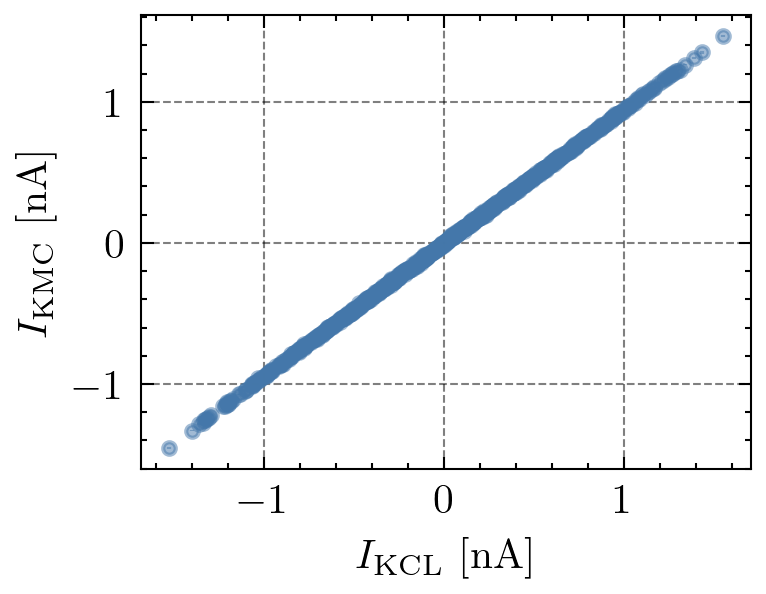

In [360]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot()
w, h = fig.get_size_inches()
scale = 0.75
fig.set_size_inches(w * scale, h * scale)
for N in N_PARTICLES:
    _ = ax.errorbar(y_kcl[N]*1e9,y[N]*1e9,yerr=y_e[N]*1e9, marker='.', ls='', color=BLUE_COLOR, alpha=0.5)
_ = ax.set_xlabel("$I_\\textrm{KCL}~[\mathrm{nA}]$")
_ = ax.set_ylabel("$I_\\textrm{KMC}~[\mathrm{nA}]$")

fig.savefig(f"plots/pdf/I_KMC_vs_I_KCL.pdf", transparent=False)
fig.savefig(f"plots/svg/I_KMC_vs_I_KCL.svg", transparent=True)
fig.savefig(f"plots/png/I_KMC_vs_I_KCL.png", transparent=False)

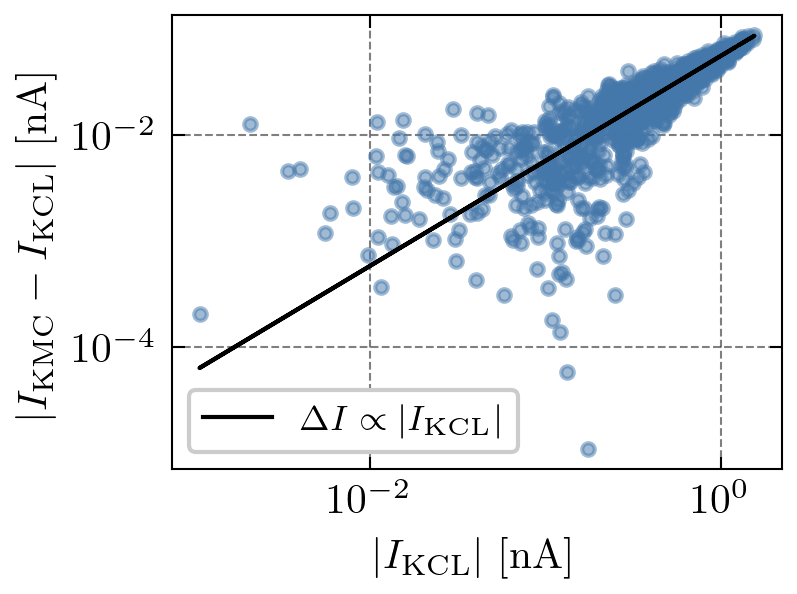

In [361]:
def power_law(x,a,b):
    return a*x**b

fig = plt.figure(dpi=300)
ax = fig.add_subplot()
w, h = fig.get_size_inches()
scale = 0.75
fig.set_size_inches(w * scale, h * scale)
for N in N_PARTICLES:
    mask = np.abs(y_kcl[N]*1e9) > 0.1
    p,c = curve_fit(power_law, np.abs(y_kcl[N]*1e9)[mask], np.abs(y[N]*1e9-y_kcl[N]*1e9)[mask])
    _ = ax.plot(np.abs(y_kcl[N]*1e9), np.abs(y[N]*1e9-y_kcl[N]*1e9), marker='.', ls='', alpha=0.5, color=BLUE_COLOR)
    _ = ax.plot(np.abs(y_kcl[N]*1e9), power_law(np.abs(y_kcl[N]*1e9),*p), color='black', label='$\\Delta I \propto |I_\\textrm{KCL}|$')
# _ = ax.plot(np.abs(y_kcl[3]*1e9),power_law(np.abs(y_kcl[3]*1e9),0.05,0.5))
_ = ax.set_xlabel("$|I_\\textrm{KCL}|~[\mathrm{nA}]$")
_ = ax.set_ylabel("$|I_\\textrm{KMC}-I_\\textrm{KCL}|~[\mathrm{nA}]$")
_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.legend(fontsize='small', loc='lower left')

fig.savefig(f"plots/pdf/DI_vs_I_KCL.pdf", transparent=False)
fig.savefig(f"plots/svg/DI_vs_I_KCL.svg", transparent=True)
fig.savefig(f"plots/png/DI_vs_I_KCL.png", transparent=False)

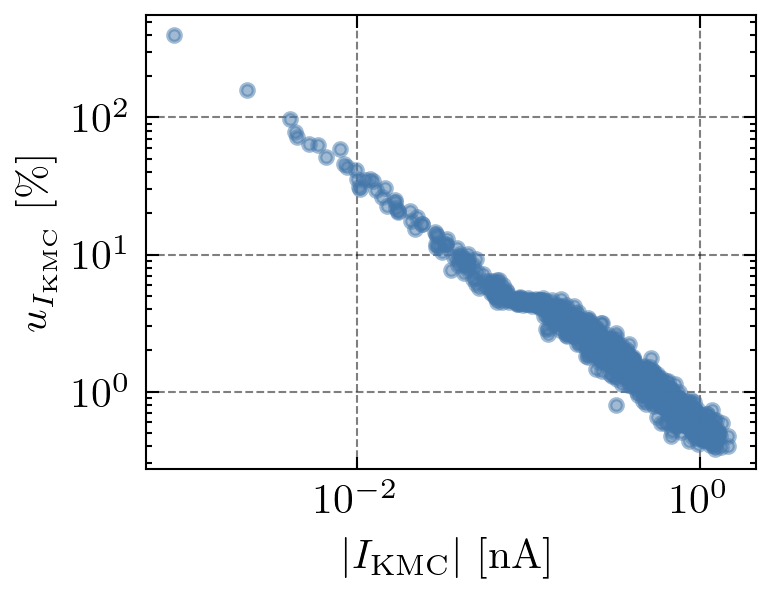

In [362]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot()
w, h = fig.get_size_inches()
scale = 0.75
fig.set_size_inches(w * scale, h * scale)
for N in N_PARTICLES:
    _ = ax.plot(np.abs(y[N]*1e9), y_e[N]/np.abs(y[N])*100, marker='.', ls='', alpha=0.5, color=BLUE_COLOR)
_ = ax.set_xlabel("$|I_\\textrm{KMC}|~[\mathrm{nA}]$")
_ = ax.set_ylabel("$u_{I_\\textrm{KMC}}~[\%]$")
_ = ax.set_xscale('log')
_ = ax.set_yscale('log')

fig.savefig(f"plots/pdf/rel_error_KMC_vs_I_KMC.pdf", transparent=False)
fig.savefig(f"plots/svg/rel_error_KMC_vs_I_KMC.svg", transparent=True)
fig.savefig(f"plots/png/rel_error_KMC_vs_I_KMC.png", transparent=False)

### Potentials

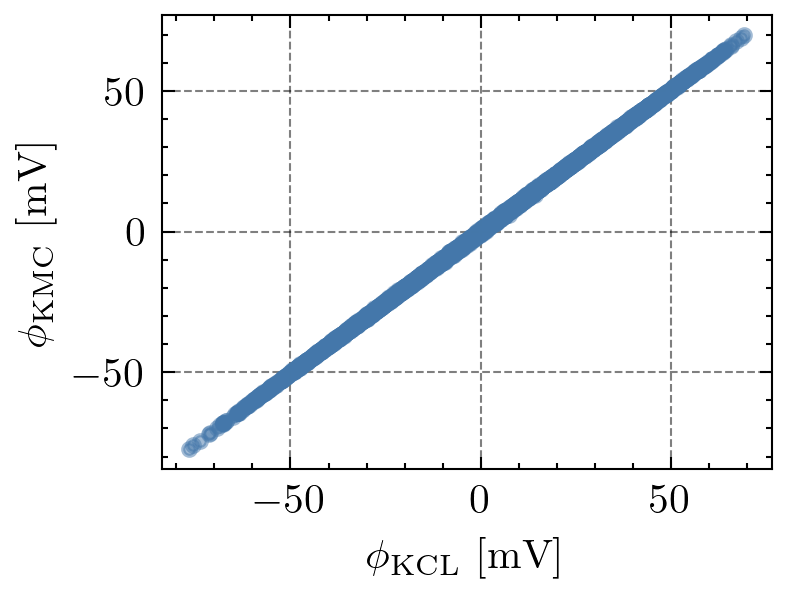

In [363]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot()
w, h = fig.get_size_inches()
scale = 0.75
fig.set_size_inches(w * scale, h * scale)
for N in N_PARTICLES:
    for i in range(N*N):
        _ = ax.plot(np_p_kcl[N][:,i]*1000,np_p[N][:,i]*1000,marker='.', ls='', color=BLUE_COLOR, alpha=0.5)
_ = ax.set_xlabel("$\phi_\\textrm{KCL}~[\mathrm{mV}]$")
_ = ax.set_ylabel("$\phi_\\textrm{KMC}~[\mathrm{mV}]$")

fig.savefig(f"plots/pdf/pot_KMC_vs_pot_KCL.pdf", transparent=False)
fig.savefig(f"plots/svg/pot_KMC_vs_pot_KCL.svg", transparent=True)
fig.savefig(f"plots/png/pot_KMC_vs_pot_KCL.png", transparent=False)